In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [15]:
# load SBML model and get parameter labels
modelfile = os.getcwd()+'/models/240226MC_FULL.sbml' # filled nan values with mean for now
r = te.loadSBMLModel(modelfile)
parameter_values = r.getGlobalParameterValues()

In [16]:
# get data and metadata for experiment
with open('data/230623_Kinetics_DA/simulation_ready.pkl', 'rb') as f:
    simulation_ready = pickle.load(f)
    init_concentrations = simulation_ready['init_concentrations']   
    metadata = simulation_ready['metadata']
    measurements = simulation_ready['measurements']

In [17]:
# make sure we can set the initial concentrations
for i in init_concentrations.keys():
    try:
        r.removeInitialAssignment(i) 
    except:
        pass
r.exportToSBML(os.getcwd()+'/models/240226MC_FULL.sbml')

In [18]:
# get all the parameters that can vary during the fitting
kinetics_labels = [p for p in r.getGlobalParameterIds() if np.any([k in p for k in ['Km','Kcat','Ki']])]
Gi_labels = [p for p in r.getGlobalParameterIds() if 'Gi' in p ]
species_labels = np.array(r.getFullStoichiometryMatrix().rownames);
metabolites_labels = species_labels[['EC' not in label for label in species_labels]]
metabolites_list = ['v'+str(i) for i in range(1,len(metabolites_labels)+1)]
parameter_labels = kinetics_labels + Gi_labels + metabolites_list # + list(metabolites_labels)
parameter_labels.append('rel0') # what are good bounds for this?

# make upper and lower bounds
upper = np.array([r[i]*10 for i in kinetics_labels] + [1 for _ in Gi_labels] + [r[i]*10 for i in metabolites_labels] + [1000])
lower = np.array([r[i]/10 for i in kinetics_labels] + [0 for _ in Gi_labels] + [r[i]*10 for i in metabolites_labels] + [10])

# define variables that don't change during fitting, but could be different across samples
# (dilution factor, biosynthesis metabolites, which enzymes are present)
variables = init_concentrations.copy()
for s in metadata['sample_labels']:
    # variables[s] = {**variables[s] , **{'dilution_factor':metadata['dilution_factor'][s]}}
    variables[s] = {**variables[s] , **{p:1 for p in r.getGlobalParameterIds() if 'p_EC' in p}}

Traceback (most recent call last):
  File "C:\Users\Diego Alba\AppData\Local\Temp\ipykernel_9652\2405158685.py", line 4, in <module>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.


In [21]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi
myprob = SBMLGlobalFit_Multi(
    model = modelfile, 
    data = measurements, 
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=metadata,
    variables=variables,
    scale=True)

prob = pg.problem(myprob)

Traceback (most recent call last):
  File "c:\Users\Diego Alba\Documents\GitHub\ECFERS\src\fitting\pygmo_problems.py", line 248, in __init__
    self.species_labels = np.array(r.getFullStoichiometryMatrix().rownames)
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.


In [22]:
myprob.fitness(upper)

Error opening file c:\Users\Diego Alba\Documents\GitHub\ECFERS/models/binaries/model_state_9652.b: No such file or directory
Could not save state
Error opening file c:\Users\Diego Alba\Documents\GitHub\ECFERS/models/binaries/model_state_9652.b: No such file or directory


c:\Users\Diego Alba\Documents\GitHub\ECFERS\src\fitting\pygmo_problems.py:322: RuntimeWarning:

All-NaN slice encountered

Traceback (most recent call last):
  File "c:\Users\Diego Alba\Documents\GitHub\ECFERS\src\fitting\pygmo_problems.py", line 307, in _simulate
    results = r.simulate(0,self.metadata['timepoints'][sample][-1],1000)[:,1:].__array__()
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Traceback (most recent call last):
  File "c:\Users\Diego Alba\Documents\GitHub\ECFERS\src\fitting\pygmo_problems.py", line 307, in _simulate
    results = r.simulate(0,self.metadata['timepoints'][sample][-1],1000)[:,1:].__array__()
RuntimeError: Object of type <class 'NamedAr

[1.5454029901504028e-05]

In [27]:
udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})
mybfe = pg.bfe(udbfe)

# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
algos = []
pops = []
for i in range(5):
    a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.01, variant=5, neighb_type=2, neighb_param=4)
    # a = pg.gaco(gen=10)
    a.set_bfe(mybfe)
    algo = pg.algorithm(a)
    algo.set_verbosity(1)
    algos.append(algo)
    pops.append(pg.population(prob, size = 0))

In [15]:
import ipyparallel as ipp
client = ipp.Client(profile='cheme-ecfers')
len(client[:])

720

In [28]:
total_nodes = 40*18
init_std = 0.17

for p in pops:
    xs = (np.expand_dims(myprob._scale(lower*10),-1)@np.ones((1,total_nodes))*(1+np.random.normal(0, init_std,(len(lower),total_nodes)))).T + np.random.uniform(-0.08, 0.3, (total_nodes,len(lower)))    
    fs = udbfe._view.map_sync(myprob.fitness,xs)
    list(map(p.push_back, xs, fs))

In [18]:
import pickle

with open('logs.dat', 'rb') as file:
    logs = pickle.load(file)

with open('checkpoint.dat', 'rb') as file:
    pops = pickle.load(file)

In [30]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
logs = [[] for _ in range(5)]
for i in range(100):
    print(now() + ' - Starting evolution ' + str(i))
    pops = [a.evolve(p) for a,p in zip(algos,pops)]
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))

    for i,a in enumerate(algos):
        logs[i].append(np.array(a.extract(pg.pso_gen).get_log()))

    with open('logs_c.dat', 'wb') as file:
        pickle.dump(logs, file)

    with open('checkpoint_c.dat', 'wb') as file:
        pickle.dump(pops, file)

    # if np.min([p.champion_f for p in pops]) < prob.extract(SBMLGlobalFit)._residual(result[:,1:].__array__()*(1.055),result[:,1:].__array__()):
    #     break
    

26-02-2024, 15:14:23 - Starting evolution 0

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            720    0.000330912     0.00613174      0.0321166        3.61696
      2           1440    0.000330912     0.00640894      0.0296414        3.50309
      3           2160    0.000330912     0.00686326      0.0270257        3.40402
      4           2880    0.000330912     0.00713003      0.0244426        3.32725
      5           3600    0.000330912     0.00714424       0.022215        3.27261
      6           4320    0.000330912     0.00687389      0.0200654        3.23753
      7           5040    0.000330912     0.00648715       0.018118        3.21887
      8           5760    0.000330912     0.00609627      0.0163486        3.21173
      9           6480    0.000330912     0.00575704      0.0146382        3.21197
     10           7200    0.000330849     0.00515447      0.0133969        3.21593
Exit condition -- generations = 10

   Gen

Text(0.5, 1.0, 'Convergence curves (n=5, independent; p=720) for fitting PLACEHOLDER')

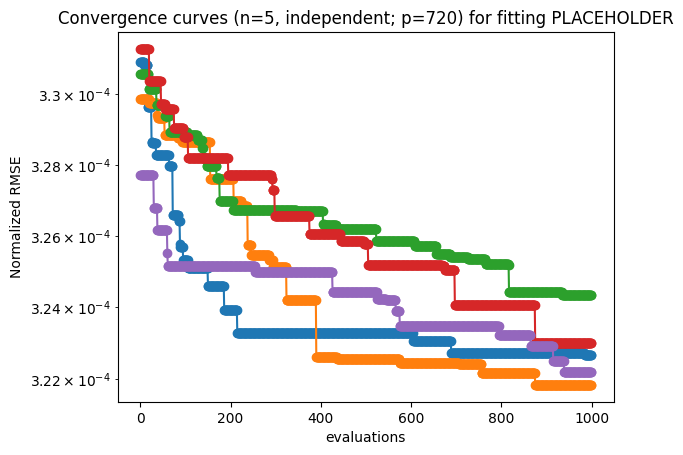

In [31]:
results = [np.concatenate(l,axis=0) for l in logs]
[plt.plot(res[:,2],'o-') for res in results]
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('Normalized RMSE')
plt.xlabel('evaluations')
plt.title('Convergence curves (n=5, independent; p=720) for fitting PLACEHOLDER')  

(array([ 20.,  67., 122., 159., 179., 165., 117.,  58.,  26.,   5.]),
 array([0.        , 0.04133539, 0.08267078, 0.12400617, 0.16534156,
        0.20667695, 0.24801234, 0.28934773, 0.33068312, 0.37201851,
        0.4133539 ]),
 <BarContainer object of 10 artists>)

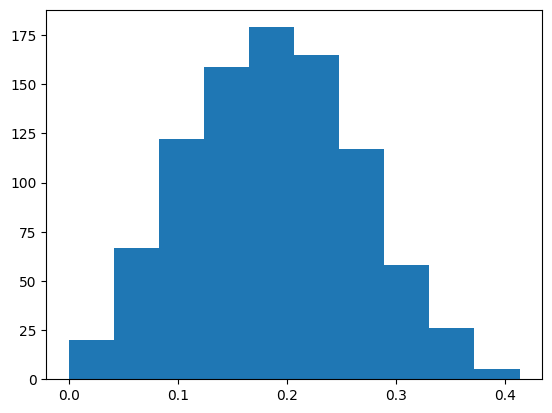

In [99]:
plt.hist(pops[0].get_x()[4,:])

In [105]:
len(myprob.parameter_labels)

887

In [102]:
pops[0].champion_x.shape

(918,)

(-1.9676165070882963, 41.328060545535)

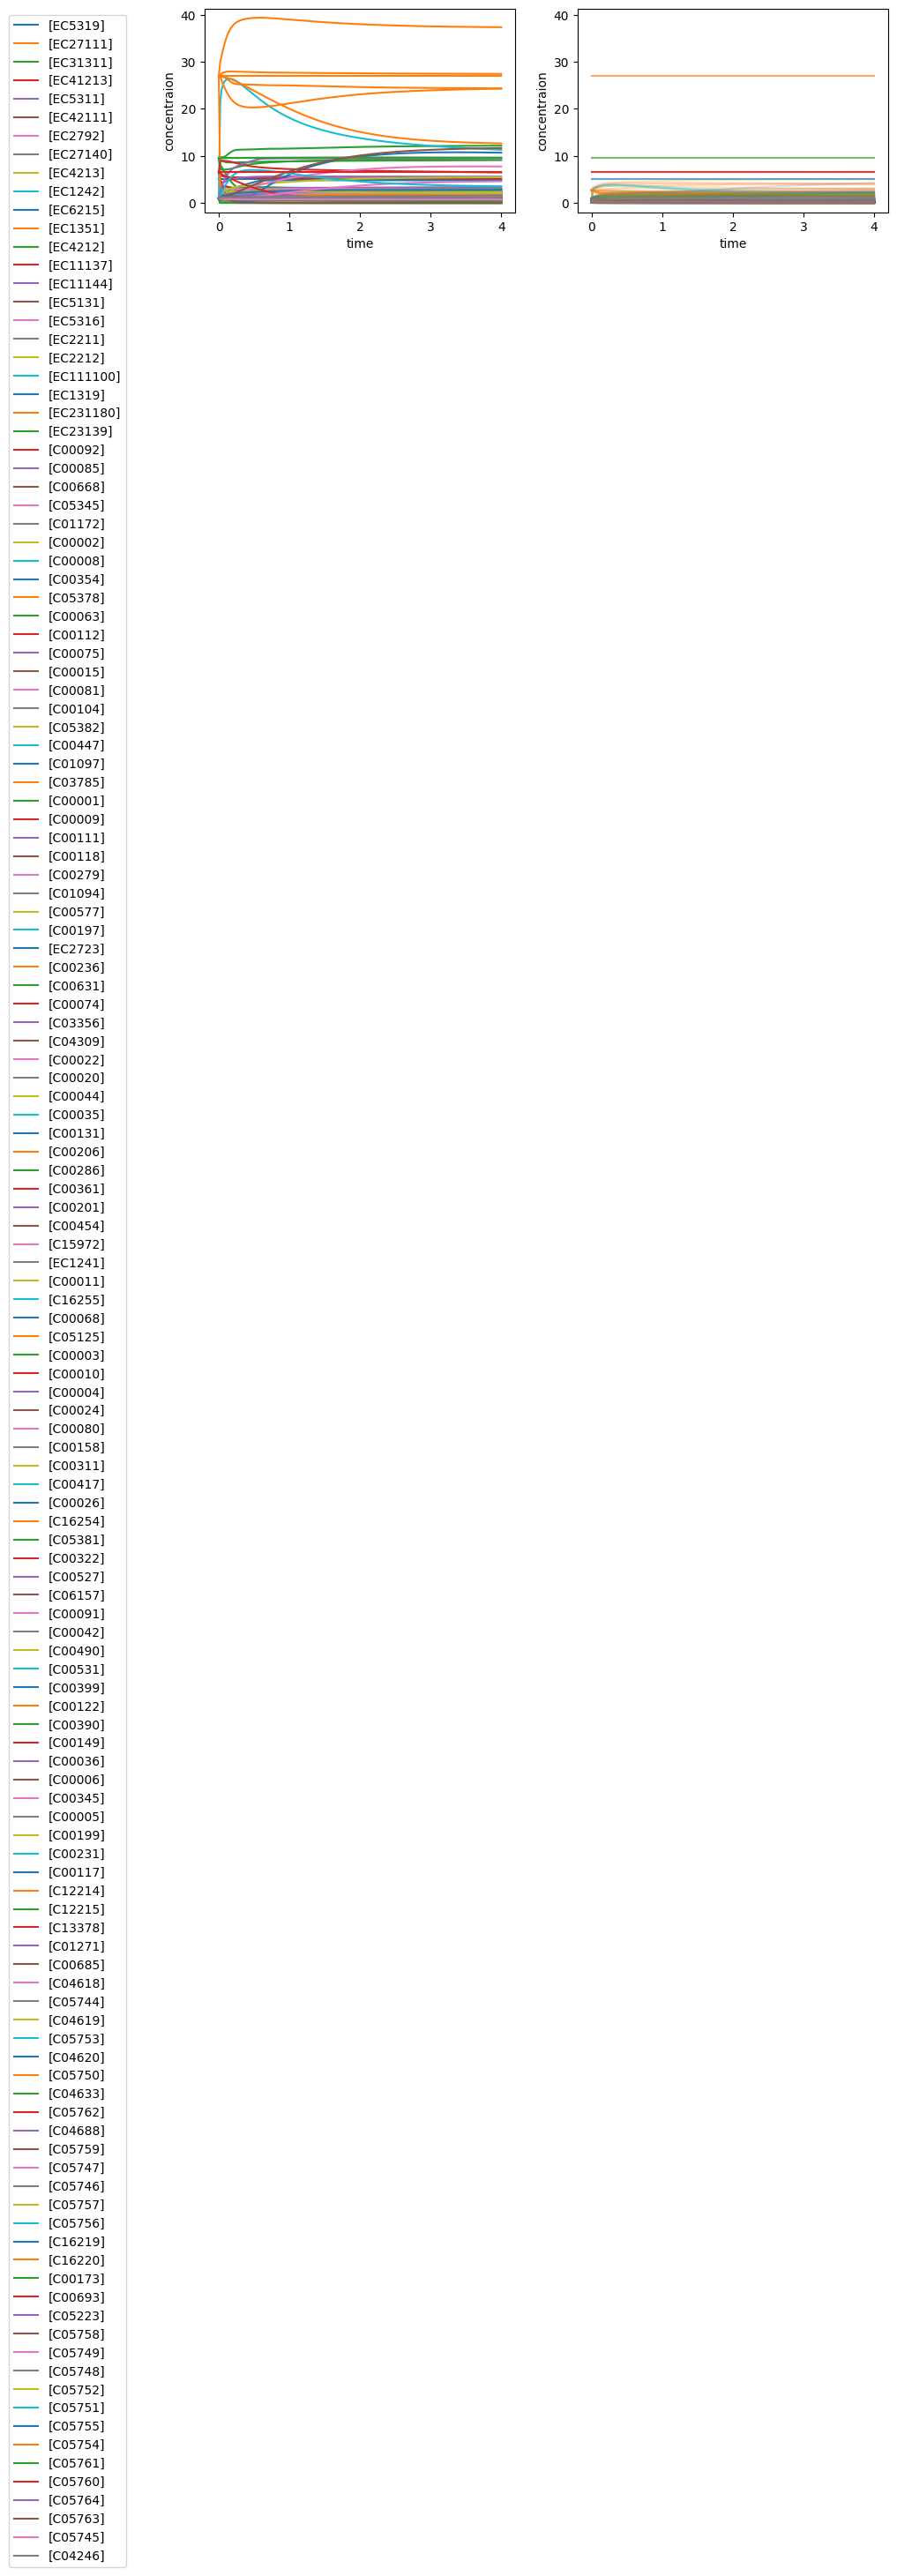

In [32]:
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
plt.figure(figsize=(10,3))
a = plt.subplot(1,2,1)
a.plot(result['time'],result[:,20:].__array__())
a.legend(result.colnames[1:], bbox_to_anchor=(-0.65, 1), loc='upper left' )
a.set_xlabel('time')
a.set_ylabel('concentraion')
#a.set_yscale('log')

b = plt.subplot(1,2,2)
mean_result = result*0
for k,c in enumerate([p.champion_x for p in pops]):
    r.resetToOrigin()
    for p,v in zip(parameter_labels,myprob._unscale(c)):
        try:
            r[p] = v
        except Exception as e:
            raise(e)

    try:
        result2 = r.simulate(**settings['simulation'])
    except Exception as e:
        print(k)
        print(e)
        result2 = result*0
    mean_result += result2
    
    b.set_prop_cycle(color=colors)
    b.plot(result['time'], result2[:,20:].__array__(), alpha = 0.2)

b.set_prop_cycle(color=colors)
#b.plot(result['time'][settings['fit_to_rows']], (mean_result[:,1:].__array__()/8)[:,settings['fit_to_cols']][settings['fit_to_rows'],:],'o')
b.set_xlabel('time')
b.set_ylabel('concentraion')
#b.set_yscale('log')
b.set_ylim(a.get_ylim())